# 외국 뉴스사이트에 가장많이 나온 영단어 맞추기 게임 만들기

* 난이도 : ★★★★☆☆☆☆☆☆
* 필요라이브러리: requests, BeautifulSoup4


* 이전 강좌에서 만들었던 영어단어 맞추기 게임의 확장판 입니다.
* 문제를 정해놓고 출제하는 방식이 아니라 실제 외국 사이트에서 단어를 크롤링해서 자동 출제되는 방식을 구현합니다.

## 외국 뉴스 사이트에서 영어 뉴스 가져오기

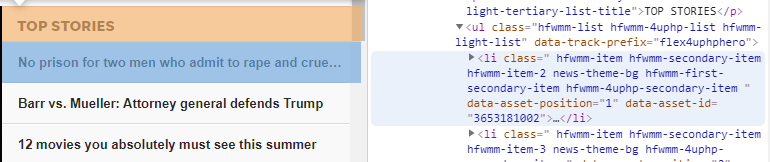


* USA Today 사이트를 대상으로 합니다.
* 뉴스 사이트 메인페이지에서 가장 접근하기 용이한 TOP STORIES 카테고리를 대상으로 결정 했습니다.
* TOP STORIES 의 링크를 얻어 상세 페이지에 접근하여 본문 내용을 파싱합니다.

In [ ]:
# 크롤링에 필요한 라이브러리
import requests
from bs4 import BeautifulSoup

def get_news():
    '''뉴스 사이트에서 뉴스 문자열 데이터를 파싱 하는 함수
    Returns:
        str : 문자열 뉴스 데이터(소문자 변환)
    '''
    
    # 뉴스 사이트 메인페이지 주소
    url = "https://www.usatoday.com/"
    r = requests.get(url)
    bs = BeautifulSoup(r.text, "lxml")
    
    # USA Today TOP STORIES 는 ul > li > a 로 접근하여 가져옵니다.
    # 개발자도구를 참조하여 해당 css selector를 사용한 이유를 확인해보시기 바랍니다.
    lists = bs.select("ul.hfwmm-list.hfwmm-4uphp-list.hfwmm-light-list > li > a")
    
    # 탑스토리 요소 반복
    for a in lists:
        # 링크주소가 절대경로가 아닌 상대경로라 직접 도메인과 합쳐
        # 절대 경로로 바꿔줍니다.
        href = "https://www.usatoday.com" + a["href"]
        
        # 뉴스 상세 페이지에 접속합니다.
        r = requests.get(href)
        bs = BeautifulSoup(r.text, "lxml")
        
        # 상세페이지의 본문 내용은 아래의 Selector 로 접근합니다.
        # 역시 개발자도구를 참조하여 Selector 의 내용을 이해하는게 좋습니다.
        lines = bs.select("div.asset-double-wide.double-wide.p402_premium > p.p-text")

        # 본문 내용 태그에서 text 만 꺼내 리스트에 저장합니다.
        contents = [l.text for l in lines]
        # 저장된 텍스트 리스트를 하나의 str 문자열 변수로 변환합니다.
        contents = " ".join(contents)

        # 1개의 뉴스데이터만 샘플로 사용할 예정이라 for 문을 무시하고 여기서 return 합니다.
        return contents.lower()
    return None

print(get_news())

### 가져온 스트링값을 문제 출제용 리스트로 만듭니다.

* 정규식을 사용해 오류나 의미없는 단어 출제를 방지하기 위해서 문자열 데이터에서 4글자 이상 15글자 미만의 연속된 글자만 단어로 인식하게 정리합니다.
* 정규식을 사용하기 위해 re 라이브러리를 사용합니다.
* 정리된 단어목록중에 최소 2번이상의 반복된 빈도수가 있는 단어만 문제로 사용합니다.

In [ ]:
# 정규식을 사용하기위한 라이브러리
import re

def make_q_list(strings):
    '''문자열 데이터를 정리하여 문제를 내기 편하게 만들어주는 함수
    Args:
        strings (str) : 문자열 데이터
    '''
    
    # 정규식 패턴 등록
    # r 옵션은 역슬러쉬\ 를 그대로 인식하라는 예약어
    # r 옵션을 안쓰면 \\ 이렇게 표기해야함
    # [a-z] 까지 {4, 15} 4자에서 15자까지
    match_pattern = re.findall(r'\b[a-z]{4,15}\b', strings)
    
    # 단어의 반복횟수를 카운팅 해서 기억할 임시 딕셔너리 변수
    frequency = {}
    
    # 최종 문제 목록
    q_dict = []
    # 정규식에 의해 필터링 된 단어 리스트 반복
    for word in match_pattern:
        # frequency 에 단어가 있으면 카운트값 저장 (없으면 디폴트 0)
        count = frequency.get(word, 0)
        # 해당 단어의 카운트 횟수 증가
        # frequency[단어] = 카운트 + 1 
        frequency[word] = count + 1
    
    # 문제수 카운팅 변수
    q_count = 0
    # 단어만 빼서 리스트에 저장
    frequency_list = frequency.keys()
    # 리스트의 단어 요소 반복
    for word in frequency_list:
        # 해당 단어의 카운트 값을 딕셔너리에서 구해 count 변수에 저장
        count = frequency[word]
        
        # 2번이상 반복된 단어인 경우
        if count > 1:
            # 해당 단어의 한글 뜻 구해와야함
            kor = ""
            if kor == "" or kor is None:
                continue
            q_dict.append({kor: word})
            
            # 문제수 증가
            q_count += 1
            # 샘플로 20문제만..
            if q_count > 20:
                break
                
    # 문제 목록 리턴
    return q_dict
    
make_q_list("shane piche admitted to raping a 14-year-old girl who rode the school bus he drove. michael wysolovski admitted to keeping a teenage girl in sexual captivity for more than a year. last thursday, two separate judges in two separate states ruled neither would be going to prison.")

### 네이버 사전을 활용해서 영어단어 해석하기

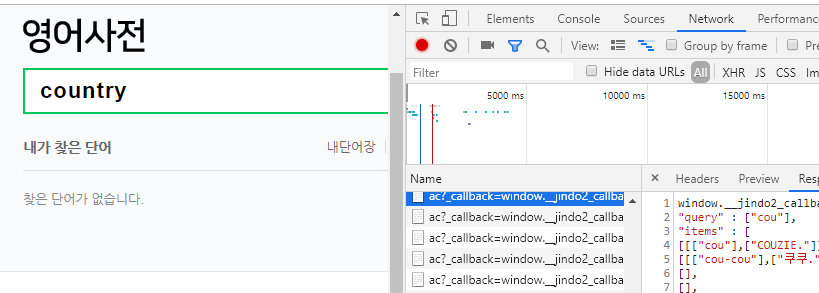


* 네이버 영어사전에 영어 단어를 검색해보면 키 입력과 동시에 실시간 번역이되는걸 볼 수 있습니다.
* 우리는 이 실시간 번역시에 사용하는 네이버 API 를 활용하여 영어단어를 번역해 보기로 합니다.
* API 의 리턴값이 json 형태기 때문에 json 라이브러리를 import 해야 합니다.
* API 주소: https://ac.dict.naver.com/enendict/ac?q=country&q_enc=utf-8&st=11001

***이 API는 네이버에서 공식지원하는 API 가 아니기 때문에 개인적인 용도외의 서비스 목적으로 사용하실 수 없습니다. 서비스 목적으로 사용하시려면 공식 네이버 번역 API를 사용하셔야 합니다.***

In [ ]:
# 크롤링에 필요한 기본 라이브러리
import requests
# API 의 결과값을 처리하기 위한 라이브러리
import json

def naver_translate(word):
    '''영어단어를 네이버 API 를 활용하여 자동 번역해서 결과를 리턴하는 함수
    Args:
        word (str) : 영어단어
    Returns:
        str : 번역된 영어단어의 뜻
    '''
    try:
        url = "https://ac.dict.naver.com/enendict/ac?q={}&q_enc=utf-8&st=11001".format(word)
        r = requests.get(url)
        # API 의 내용을 JSON 라이브러리를 사용해 dict 형태로 변환
        jdata = json.loads(r.text)
        
        # jdata는 아래의 모양입니다. 여기서 뜻만 빼내야 합니다.
        # {'query': ['country'], 'items': [[[['country'], ['국가, 나라, 지역[고장], 국민; 국가, 시골, 전원']], [['countryside'], ['시골 지역, 전원 지대']], [['countryman'], ['동포 , 같은 나라 사람, 시골 남자']], [['countrywide'], ['전국에 걸쳐']], [['country-by-country'], ['국가별']], [['country club'], ['컨트리클럽']], [['country code'], ['국가 번호']], [['country music'], ['']], [['country of origin'], ['원산지, 출생지']], [['countrylike'], ['시골풍의[으로], 촌스러운[스럽게]']]], [[['cross-country'], ['들판을 횡단하는, 크로스컨트리의, 국토를 횡단하는, 크로스컨트리 달리기[스키] 대회']], [['country-by-country'], ['국가별']], [['in-country'], ['국내의, 국내에서 일어나는']]], [], [], []]}
        
        # 쉽게 딕셔너리의 items 키값을 
        # jdata["item"][0] 찍어보고
        # jdata["item"][0][0] 찍어보고...
        # 이런식으로 찍어보면서 이해하시는게 좋습니다.
        return jdata["items"][0][0][1][0]
    except:
        pass
    return None

print(naver_translate("country"))

### 이제 조각난 함수들을 모아 프로그램 전체를 완성합니다.
* 기존의 함수를 마무리해서 완성하고
* 문제를 내는 함수를 작성합니다.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re # 정규식을 사용하기 위한 라이브러리
import json # json 을 사용하기 위한 라이브러리
import random # 랜덤의 shuffle 을 사용하기 위함
import os # 화면을 지우고 pause 하기 위해 사용

def get_news():
    '''뉴스 사이트에서 뉴스 문자열 데이터를 파싱 하는 함수
    Returns:
        str : 문자열 뉴스 데이터(소문자 변환)
    '''
    
    # 뉴스 사이트 메인페이지 주소
    url = "https://www.usatoday.com/"
    r = requests.get(url)
    bs = BeautifulSoup(r.text, "lxml")
    
    # USA Today TOP STORIES 는 ul > li > a 로 접근하여 가져옵니다.
    # 개발자도구를 참조하여 해당 css selector를 사용한 이유를 확인해보시기 바랍니다.
    lists = bs.select("ul.hfwmm-list.hfwmm-4uphp-list.hfwmm-light-list > li > a")
    
    # 탑스토리 요소 반복
    for a in lists:
        # 링크주소가 절대경로가 아닌 상대경로라 직접 도메인과 합쳐
        # 절대 경로로 바꿔줍니다.
        href = "https://www.usatoday.com" + a["href"]
        
        # 뉴스 상세 페이지에 접속합니다.
        r = requests.get(href)
        bs = BeautifulSoup(r.text, "lxml")
        
        # 상세페이지의 본문 내용은 아래의 Selector 로 접근합니다.
        # 역시 개발자도구를 참조하여 Selector 의 내용을 이해하는게 좋습니다.
        lines = bs.select("div.asset-double-wide.double-wide.p402_premium > p.p-text")

        # 본문 내용 태그에서 text 만 꺼내 리스트에 저장합니다.
        contents = [l.text for l in lines]
        # 저장된 텍스트 리스트를 하나의 str 문자열 변수로 변환합니다.
        contents = " ".join(contents)

        # 1개의 뉴스데이터만 샘플로 사용할 예정이라 for 문을 무시하고 여기서 return 합니다.
        return contents.lower()
    return None


def naver_translate(word):
    '''영어단어를 네이버 API 를 활용하여 자동 번역해서 결과를 리턴하는 함수
    Args:
        word (str) : 영어단어
    Returns:
        str : 번역된 영어단어의 뜻
    '''
    try:
        url = "https://ac.dict.naver.com/enendict/ac?q={}&q_enc=utf-8&st=11001".format(word)
        r = requests.get(url)
        # API 의 내용을 JSON 라이브러리를 사용해 dict 형태로 변환
        jdata = json.loads(r.text)
        
        # jdata는 아래의 모양입니다. 여기서 뜻만 빼내야 합니다.
        # {'query': ['country'], 'items': [[[['country'], ['국가, 나라, 지역[고장], 국민; 국가, 시골, 전원']], [['countryside'], ['시골 지역, 전원 지대']], [['countryman'], ['동포 , 같은 나라 사람, 시골 남자']], [['countrywide'], ['전국에 걸쳐']], [['country-by-country'], ['국가별']], [['country club'], ['컨트리클럽']], [['country code'], ['국가 번호']], [['country music'], ['']], [['country of origin'], ['원산지, 출생지']], [['countrylike'], ['시골풍의[으로], 촌스러운[스럽게]']]], [[['cross-country'], ['들판을 횡단하는, 크로스컨트리의, 국토를 횡단하는, 크로스컨트리 달리기[스키] 대회']], [['country-by-country'], ['국가별']], [['in-country'], ['국내의, 국내에서 일어나는']]], [], [], []]}
        
        # 쉽게 딕셔너리의 items 키값을 
        # jdata["item"][0] 찍어보고
        # jdata["item"][0][0] 찍어보고...
        # 이런식으로 찍어보면서 이해하시는게 좋습니다.
        return jdata["items"][0][0][1][0]
    except:
        pass
    return None


def make_q_list(strings):
    '''문자열 데이터를 정리하여 문제를 내기 편하게 만들어주는 함수
    Args:
        strings (str) : 문자열 데이터
    '''
    
    # 정규식 패턴 등록
    # r 옵션은 역슬러쉬\ 를 그대로 인식하라는 예약어
    # r 옵션을 안쓰면 \\ 이렇게 표기해야함
    # [a-z] 까지 {4, 15} 4자에서 15자까지
    match_pattern = re.findall(r'\b[a-z]{4,15}\b', strings)
    
    # 단어의 반복횟수를 카운팅 해서 기억할 임시 딕셔너리 변수
    frequency = {}
    
    # 최종 문제 목록
    q_dict = []
    # 정규식에 의해 필터링 된 단어 리스트 반복
    for word in match_pattern:
        # frequency 에 단어가 있으면 카운트값 저장 (없으면 디폴트 0)
        count = frequency.get(word, 0)
        # 해당 단어의 카운트 횟수 증가
        # frequency[단어] = 카운트 + 1 
        frequency[word] = count + 1
    
    # 문제수 카운팅 변수
    q_count = 0
    # 단어만 빼서 리스트에 저장
    frequency_list = frequency.keys()
    # 리스트의 단어 요소 반복
    for word in frequency_list:
        # 해당 단어의 카운트 값을 딕셔너리에서 구해 count 변수에 저장
        count = frequency[word]
        
        # 2번이상 반복된 단어인 경우
        if count > 1:
            # 해당 단어의 한글 뜻 구해와야함
            kor = naver_translate(word)
            if kor == "" or kor is None:
                continue
            q_dict.append({kor: word})
            
            # 문제수 증가
            q_count += 1
            # 샘플로 20문제만..
            if q_count > 20:
                break
                
    # 문제 목록 리턴
    return q_dict


def q():
    '''문제출제 함수'''
    
    # 외국 뉴스 사이트에서 게시물 하나를 선택해 영어 문자열 전체를 구해옵니다.
    news_string = get_news()
    
    # 해당 영어 문자열을 단어별로 나누고 카운팅하고 번역해서 문제용 리스트로 만듭니다
    q_list = make_q_list(news_string)
    
    # 문제 리스트를 랜덤하게 셔플 합니다.
    random.shuffle(q_list)

    # 문제당 기회는 5번
    chance = 5

    # 문제 리스트 요소 반복
    for i in range(0, len(q_list)):
        # 화면 지움
        os.system("cls")
        
        # 셔플된 리스트에서 문제를 하나 꺼내 q 에 저장
        q = q_list[i]
        
        # q의 키 (번역된 한국어)
        kor = list(q.keys())[0]
        
        # q의 키에 해당하는 영어 단어
        english = q.get(kor)

        # 화면에 문제 출력
        print("*" * 90)
        print("문제: {}".format(kor))
        print("*" * 90)

        # 정답 기회만큼 반복
        for j in range(0, chance):
            # 사용자에게 문제의 답을 입력받습니다.
            user_input = input("위의 뜻이 의미하는 단어를 입력하세요> ")
            
            # 입력단어와 문제 단어가 맞다면 정답
            # 정답시 기회 반복문 탈출
            if user_input == english:
                print("정답!! {} 문제 남음".format(len(q_list) - i))
                os.system("pause")
                break
            else:
                # 남은 기회 구함
                n = chance - (j + 1)
                
                # 시도횟수에 따른 힌트 출력
                if j == 0:
                    print("{} 가 아닙니다!!! {} 번 기회가 있습니다.".format(user_input, n))
                elif j == 1:
                    print("{} 가 아닙니다!!! {} 번 기회가 있습니다. 힌트: {}로 시작".format(user_input, n, english[0]))
                elif j == 2:
                    hint = " _ " * int(len(english) - 2)
                    print("{} 가 아닙니다!!! {} 번 기회가 있습니다. 힌트: {} {} {}로 시작".format(user_input, n, english[0], english[1], hint))
                elif j == 3:
                    hint = " _ " * int(len(english) - 3)
                    print("{} 가 아닙니다!!! {} 번 기회가 있습니다. 힌트: {} {} {} {}로 시작".format(user_input, n, english[0], english[1], english[2], hint))
                else:
                    print("틀렸습니다!!!! 정답은 {} 입니다.".format(english))
                    os.system("pause")
    # 문제 리스트 반복문을 탈출했으면 문제 종료
    print("모든 문제를 종료했습니다.")    

# 함수 호출
q()